<a href="https://colab.research.google.com/github/nomatib/autoencoder/blob/main/pytorch_autoenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X = x_train.reshape(60000, -1)/255
X = np.array_split(X, 600, axis = 0)
X = torch.tensor(np.array(X), dtype = torch.float32).to(device)

In [2]:
class Capa:
  def __init__(self, m_neuronas, n_entradas):
    self.W = torch.normal(0, 0.05, size = (m_neuronas, n_entradas), dtype = torch.float32).to(device)
    self.b = torch.zeros(size = (m_neuronas, 1), dtype = torch.float32).to(device)
    self.c = torch.zeros(size = (m_neuronas, 1), dtype = torch.float32).to(device)-0.1
    self.d = torch.ones(size = (m_neuronas, 1), dtype = torch.float32).to(device)
  def propagar(self, a_prev):
    self.z = torch.matmul(self.W, a_prev) + self.b
    self.a = relu2(self.z, self.c, self.d)
  def retropropagar(self, dLdz_sig, W_sig, a_prev):
    self.dLdz = torch.matmul(W_sig, dLdz_sig)*relu2dz(self.z, self.c, self.d)
    self.dLdc = torch.matmul(W_sig, dLdz_sig)*relu2dc(self.z, self.c, self.d)
    self.dLdd = torch.matmul(W_sig, dLdz_sig)*relu2dd(self.z, self.c, self.d)
    self.dLdW = torch.matmul(self.dLdz, a_prev)/self.dLdz.shape[1]
    self.dLdb = torch.sum(self.dLdz, axis = 1, keepdim = True)/self.dLdz.shape[1]
  def actualizar(self, h):
    self.W = self.W - h*self.dLdW
    self.b = self.b - h*self.dLdb
    self.c = self.c - 0.05*torch.sum(self.dLdc, axis = 1, keepdim = True)/self.dLdc.shape[1]
    self.d = self.d - 0.05*torch.sum(self.dLdd, axis = 1, keepdim = True)/self.dLdd.shape[1]
class CapadeSalida:
  def __init__(self, m_neuronas, n_entradas):
    self.W = torch.normal(0, 0.05, size = (m_neuronas, n_entradas), dtype = torch.float32).to(device)
    self.b = torch.zeros(size = (m_neuronas, 1), dtype = torch.float32).to(device)
  def propagar(self, a_prev):
    self.z = torch.matmul(self.W, a_prev) + self.b
    self.a = self.z
  def retropropagar(self, y, a_prev):
    self.dLdz = self.a - y
    self.dLdW = torch.matmul(self.dLdz, a_prev)/self.dLdz.shape[1]
    self.dLdb = torch.sum(self.dLdz, axis = 1, keepdim = True)/self.dLdz.shape[1]
  def actualizar(self, h):
    self.W = self.W - h*self.dLdW
    self.b = self.b - h*self.dLdb

##################################################
def relu2(z, c, d):
  activaciones = torch.zeros_like(z)
  mask = (z > c) & (z < d)
  zc = z - c
  zd = d - z
  rr = zc * zd
  activaciones[mask] = rr[mask]
  return activaciones
def relu2dz(z, c, d):
  derivada = torch.zeros_like(z)
  mask = (z > c) & (z < d)
  rr = c + d - 2*z
  derivada[mask] = rr[mask]
  return derivada
def relu2dc(z, c, d):
  derivada = torch.zeros_like(z)
  mask = (z > c) & (z < d)
  rr = z - d
  derivada[mask] = rr[mask]
  return derivada
def relu2dd(z, c, d):
  derivada = torch.zeros_like(z)
  mask = (z > c) & (z < d)
  rr = z - c
  derivada[mask] = rr[mask]
  return derivada
def crearcapas(lista, n_entradas):
  capas = [Capa(lista[0], n_entradas)]
  for i in range(1, len(lista)):
    capas.append(Capa(lista[i], lista[i-1]))
  return capas

In [3]:
listadecapas = [784, 100]
C = crearcapas(listadecapas, 784)
salida = CapadeSalida(784, listadecapas[-1])
h = 0.1

In [4]:
for epoch in range(3000):
  #propagar
  C[0].propagar(X[0].T)
  for i in range(1, len(C)):
    C[i].propagar(C[i-1].a)
  salida.propagar(C[-1].a)
  #retropropagar
  salida.retropropagar(X[0].T, C[-1].a.T)
  C[-1].retropropagar(salida.dLdz, salida.W.T, C[-2].a.T)
  for i in range(len(C)-2, 0, -1):
    C[i].retropropagar(C[i+1].dLdz, C[i+1].W.T, C[i-1].a.T)
  C[0].retropropagar(C[1].dLdz, C[1].W.T, X[0])
  #actualizar
  salida.actualizar(h)
  for cap in C:
    cap.actualizar(h)
error = torch.sum((X[0].T - salida.a)**2, axis = 0)/salida.a.shape[0]

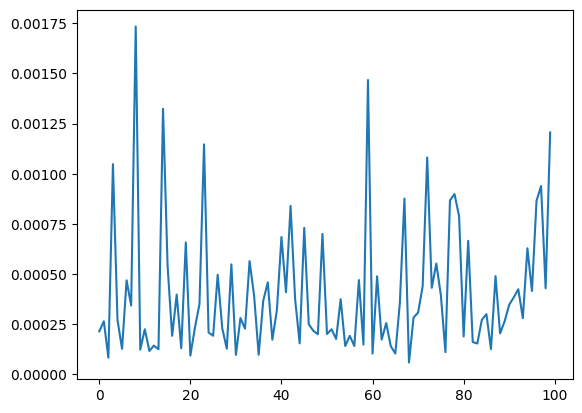

In [5]:
plt.plot(error.to("cpu"))

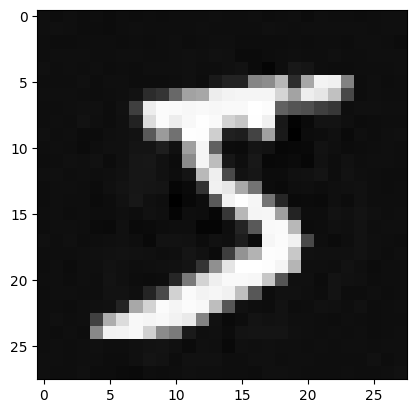

In [7]:
plt.imshow(salida.a[:,0].reshape(28, 28).to("cpu"), cmap = 'gray')